In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from scipy import stats as st
from sklearn.metrics import confusion_matrix
import math

In [11]:
%cd /content/drive/My Drive/

/content/drive/My Drive


In [12]:
!ls

 Aprendizaje	    df_carac_test.csv		 smote.csv
 Classroom	    df_y_test.csv		 X_train_PCA.csv
'Colab Notebooks'   df_y_train.csv
 DBManager	   'Lenguajes de Programación'


In [0]:
X_train = pd.read_csv('X_train_PCA.csv', sep = ",", header=0, index_col=0)
y_train = pd.read_csv('df_y_train.csv', sep = ",", header=0, index_col=0)

X_test = pd.read_csv('df_carac_test.csv', sep = ",", header=0, index_col=0)
y_test = pd.read_csv('df_y_test.csv', sep = ",", header=0, index_col=0)

In [0]:
#X_test = X_test[top_var]
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

## SMOTE

In [0]:
dataset = pd.concat([X_train, y_train], axis=1)

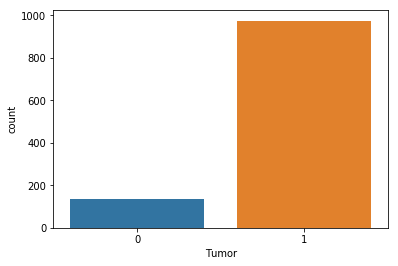

In [26]:
# Data claramente desbalanceada
import seaborn as sns
%matplotlib inline
sns.countplot(x='Tumor', data=dataset)

In [0]:
# Para smote, obtenenos los targets positivos (n_samples_1)
# y los targets negativos (n_samples_0)
# considerando que los n_samples_0 es significativamente menor, se le cambia su 
# ratio que represente el 50% (0.5) de la data

t = dataset[['Tumor']]
n_samples = t.shape[0]
n_samples_1 = (t == 1).sum()
n_samples_0 = (t == 0).sum()
n_samples_0_new = 0.50 * n_samples_1 / 0.5 - n_samples_0

In [0]:
# funcion para seleccionar un row aleatorio de un dataframe
def random_row_df(df):
    index_random = random.choice(range(len(df)))
    i = 0
    for index,row in df.iterrows():
        if i==index_random:
            d = {}
            indexs = row.index.tolist()
            values = row.values.tolist()
            for j in range(len(indexs)):
                d[indexs[j]] = [values[j]]
            df_row = pd.DataFrame(d)
            break
        i = i + 1
    return df_row

In [0]:
sel_ = dataset.loc[dataset['Tumor'] == 0].iloc[: , :-1].sample(n = int(n_samples_0_new) , replace = True , random_state = 10)

In [0]:
sel_flt= sel_.astype(float)

In [0]:
import random
# randoms para generacion de nueva data 
steps = np.random.uniform(size = int(n_samples_0_new[0]))

# generacion de nueva data (rows) con SMOTE
i=0
df_news = None
for index , row in sel_flt.iterrows():
    d = {}
    indexs = row.index.tolist()
    values = row.values.tolist()
    for j in range(len(indexs)):
        d[indexs[j]] = [values [j]]
    df_initial = pd.DataFrame(d)
    
    step = steps[i]
    
    #SMOTE
    # df_new es el punto sintetico y tomado como muestra de 
    # la clase minoritaria (0)
    df_new = df_initial - step * (df_initial - random_row_df(sel_flt))
    
    #se concatena todos nuevos rows generados del SMOTE
    df_news = pd.concat([df_news , df_new])
    i = i +1 

In [0]:
df_news['Tumor'] = 0
dataset_smoted = pd.concat([dataset , df_news])

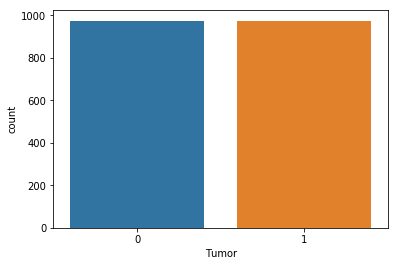

In [25]:
import seaborn as sns
%matplotlib inline
sns.countplot(x='Tumor', data=dataset_smoted)

In [27]:
dataset_smoted.groupby('Tumor').agg('size')

Tumor
0    974
1    974
dtype: int64

## Ajuste de modelos

In [0]:
import numpy as np
import pandas as pd
from scipy import stats as st
from sklearn.metrics import confusion_matrix
import math
# codigo para subir la data generada por el SMOTE (Comentado por defecto)
#
#dataset.to_csv('smote.csv', index = None, header=True)

# Para realizar el modelo, empezar leyendo la data desde aquí ignorar los pasos
# anteriores
#
dataset = pd.read_csv('smote.csv', sep = ",", header=0)


In [0]:
# Separar la data del target
X = dataset
X = dataset.iloc[:,1:]
y = dataset[['Tumor']]

In [0]:
X = X.astype('float')
X = X.drop(['Tumor'], axis=1)

In [0]:
# Separación de data de entrenamiento y de validación
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

## SVM

In [21]:
from sklearn.svm import SVC # "Support vector classifier"
from sklearn.metrics import cohen_kappa_score

mejor_score = 0
mejor_C = None
mejor_modelo_svm = None
svm_error_train = []
svm_error_val = []

C_grid = np.linspace(5,100,5).astype(int)  # ~ [250, 500, 750, ..., 25000] 

for C in C_grid: 
    modelo_svm = SVC(kernel='linear', C=C)
    modelo_svm.fit(X_train, y_train.values.ravel())
    
    score_train = modelo_svm.score(X_train, y_train.values.ravel())
    svm_error_train.append(1 - score_train)
    
    score_val = modelo_svm.score(X_val, y_val.values.ravel())
    svm_error_val.append(1 - score_val)
    
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_C = C
        mejor_modelo_svm = modelo_svm

modelo_svm = mejor_modelo_svm
modelo_svm.fit(X_train, y_train.values.ravel())

y_predict = modelo_svm.predict(X_val)

tup_y_predict = list(y_predict)
tup_y_train = list(np.transpose(y_val['Tumor']))

tup_y_predict = [int(i) for i in tup_y_predict]

print ("Mejor valor para numero de neuronas en las capas ocultas :", mejor_C)
print ("Exactitud de SVM en conjunto de entrenamiento :", modelo_svm.score(X_train, y_train.values.ravel()))
print ("Exactitud de SVM en conjunto de validación    :", modelo_svm.score(X_val, y_val.values.ravel()))
print ("Kappa Score de SVM en conjunto de validación  :", cohen_kappa_score(tup_y_train,tup_y_predict))

Mejor valor para numero de neuronas en las capas ocultas : 5
Exactitud de SVM en conjunto de entrenamiento : 1.0
Exactitud de SVM en conjunto de validación    : 0.963963963963964
Kappa Score de SVM en conjunto de validación  : 0.8610763454317898


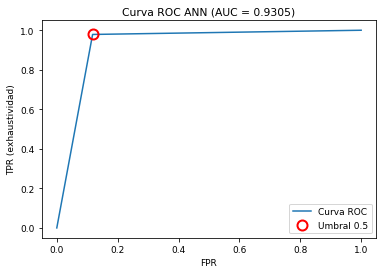

In [22]:
# Curva ROC
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred_val = modelo_svm.predict(X_val)
fpr, tpr, umbrales = metrics.roc_curve(y_val.values.ravel(), y_pred_val)
auc_roc = metrics.roc_auc_score(y_val.values.ravel(), y_pred_val)

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC ANN (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc=4, numpoints=1)

In [29]:
matriz_confusion = metrics.confusion_matrix(y_val.values.ravel(), y_pred_val)

# Mapeo según http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
TN = matriz_confusion[0,0]
FN = matriz_confusion[1,0]
FP = matriz_confusion[0,1]
TP = matriz_confusion[1,1]

print ('              +-----------------+')
print ('              |   Predicción    |')
print ('              +-----------------+')
print ('              |    +   |    -   |')
print ('+-------+-----+--------+--------+')
print ('| Valor |  +  |   %d  |   %d   |'   % (TP, FN) )
print ('| real  +-----+--------+--------+')
print ('|       |  -  |   %d   |   %d  |'    % (FP, TN) )
print ('+-------+-----+--------+--------+')
print ()
print ( 'Exactitud    : ', (TP+TN)/(TP+FN+FP+TN) )

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   92  |   2   |
| real  +-----+--------+--------+
|       |  -  |   2   |   15  |
+-------+-----+--------+--------+

Exactitud    :  0.963963963963964


##Neural Networks

In [27]:
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import random

mejor_score = 0
mejor_num_neurons_hidden = None
mejor_modelo_mlp = None
mlp_error_train = []
mlp_error_val = []

num_neurons_hidden_grid = np.linspace(1000,25000,25).astype(int)  # ~ [250, 500, 750, ..., 25000] 
print(len(num_neurons_hidden_grid))
print(num_neurons_hidden_grid)

25
[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000 12000
 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000
 25000]


In [28]:
for num_neurons_hidden in num_neurons_hidden_grid: 
    modelo_mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,activation='relu', hidden_layer_sizes=(2, num_neurons_hidden), random_state=1)
    modelo_mlp.fit(X_train, y_train.values.ravel())
    
    score_train = modelo_mlp.score(X_train, y_train.values.ravel())
    mlp_error_train.append(1 - score_train)
    
    score_val = modelo_mlp.score(X_val, y_val.values.ravel())
    mlp_error_val.append(1 - score_val)
    
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_num_neurons_hidden = num_neurons_hidden
        mejor_modelo_mlp = modelo_mlp

modelo_mlp = mejor_modelo_mlp
modelo_mlp.fit(X_train, y_train.values.ravel())

y_predict = modelo_mlp.predict(X_val)

tup_y_predict = list(y_predict)
tup_y_train = list(np.transpose(y_val['Tumor']))

tup_y_predict = [int(i) for i in tup_y_predict]

print ("Mejor valor para numero de neuronas en las capas ocultas :", mejor_num_neurons_hidden)
print ("Exactitud de ANN en conjunto de entrenamiento :", modelo_mlp.score(X_train, y_train.values.ravel()))
print ("Exactitud de ANN en conjunto de validación    :", modelo_mlp.score(X_val, y_val.values.ravel()))
print ("Kappa Score de ANN en conjunto de validación  :", cohen_kappa_score(tup_y_train,tup_y_predict))

Mejor valor para numero de neuronas en las capas ocultas : 2000
Exactitud de ANN en conjunto de entrenamiento : 0.9899799599198397
Exactitud de ANN en conjunto de validación    : 0.954954954954955
Kappa Score de ANN en conjunto de validación  : 0.8220583520359089


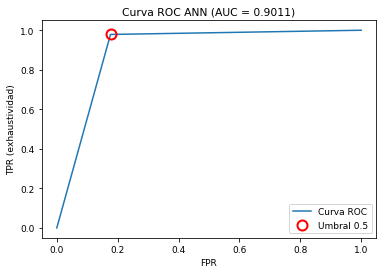

In [32]:
# Curva ROC
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred_val = modelo_mlp.predict(X_val)
fpr, tpr, umbrales = metrics.roc_curve(y_val.values.ravel(), y_pred_val)
auc_roc = metrics.roc_auc_score(y_val.values.ravel(), y_pred_val)

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC ANN (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc=4, numpoints=1)

In [33]:
matriz_confusion = metrics.confusion_matrix(y_val.values.ravel(), y_pred_val)

# Mapeo según http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
TN = matriz_confusion[0,0]
FN = matriz_confusion[1,0]
FP = matriz_confusion[0,1]
TP = matriz_confusion[1,1]

print ('              +-----------------+')
print ('              |   Predicción    |')
print ('              +-----------------+')
print ('              |    +   |    -   |')
print ('+-------+-----+--------+--------+')
print ('| Valor |  +  |   %d  |   %d   |'   % (TP, FN) )
print ('| real  +-----+--------+--------+')
print ('|       |  -  |   %d   |   %d  |'    % (FP, TN) )
print ('+-------+-----+--------+--------+')
print ()
print ( 'Exactitud    : ', (TP+TN)/(TP+FN+FP+TN) )

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   92  |   2   |
| real  +-----+--------+--------+
|       |  -  |   3   |   14  |
+-------+-----+--------+--------+

Exactitud    :  0.954954954954955


## Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

mejor_score = 0
mejor_smoothing = None
mejor_modelo_nbg = None
nbg_error_train = []
nbg_error_val = []

smoothing_grid = np.linspace(1e-01,1e-10,10).astype(int)  # ~ [250, 500, 750, ..., 25000]

In [37]:
for smoothing in smoothing_grid: 
    modelo_nbg = GaussianNB(priors=None, var_smoothing=smoothing)
    modelo_nbg.fit(X_train, y_train.values.ravel())
    
    score_train = modelo_nbg.score(X_train, y_train.values.ravel())
    nbg_error_train.append(1 - score_train)
    
    score_val = modelo_nbg.score(X_val, y_val.values.ravel())
    nbg_error_val.append(1 - score_val)
    
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_smoothing = smoothing
        mejor_modelo_nbg = modelo_nbg

modelo_nbg = mejor_modelo_nbg
modelo_nbg.fit(X_train, y_train.values.ravel())

y_predict = modelo_nbg.predict(X_val)

tup_y_predict = list(y_predict)
tup_y_train = list(np.transpose(y_val['Tumor']))

tup_y_predict = [int(i) for i in tup_y_predict]

print ("Mejor valor para smoothing :", mejor_smoothing)
print ("Exactitud de Navie Bayes en conjunto de entrenamiento :", modelo_nbg.score(X_train, y_train.values.ravel()))
print ("Exactitud de Navie Bayes en conjunto de validación    :", modelo_nbg.score(X_val, y_val.values.ravel()))
print ("Kappa Score de Navie Bayes en conjunto de validación  :", cohen_kappa_score(tup_y_train,tup_y_predict))

Mejor valor para smoothing : 0
Exactitud de Navie Bayes en conjunto de entrenamiento : 0.9128256513026052
Exactitud de Navie Bayes en conjunto de validación    : 0.9009009009009009
Kappa Score de Navie Bayes en conjunto de validación  : 0.6730923694779116


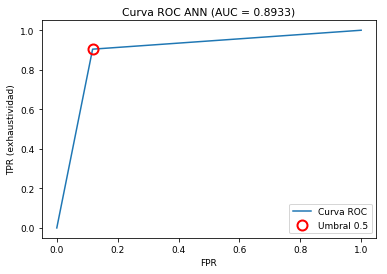

In [39]:
# Curva ROC
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred_val = modelo_nbg.predict(X_val)
fpr, tpr, umbrales = metrics.roc_curve(y_val.values.ravel(), y_pred_val)
auc_roc = metrics.roc_auc_score(y_val.values.ravel(), y_pred_val)

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC ANN (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc=4, numpoints=1)

In [40]:
matriz_confusion = metrics.confusion_matrix(y_val.values.ravel(), y_pred_val)

# Mapeo según http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
TN = matriz_confusion[0,0]
FN = matriz_confusion[1,0]
FP = matriz_confusion[0,1]
TP = matriz_confusion[1,1]

print ('              +-----------------+')
print ('              |   Predicción    |')
print ('              +-----------------+')
print ('              |    +   |    -   |')
print ('+-------+-----+--------+--------+')
print ('| Valor |  +  |   %d  |   %d   |'   % (TP, FN) )
print ('| real  +-----+--------+--------+')
print ('|       |  -  |   %d   |   %d  |'    % (FP, TN) )
print ('+-------+-----+--------+--------+')
print ()
print ( 'Exactitud    : ', (TP+TN)/(TP+FN+FP+TN) )

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   85  |   9   |
| real  +-----+--------+--------+
|       |  -  |   2   |   15  |
+-------+-----+--------+--------+

Exactitud    :  0.9009009009009009


## Random Forest

In [0]:
X_train = X
y_train = y

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

estimator_range = range(10, 310, 10)

# Definir un lista para almacenar los promedios de los Auc por cada valor de "max_depth"
AUC_scores = []

# Usa una validación cruzada de 5 folds con cada valor del "n_estimators"
for estimator in estimator_range:
    rfcla = RandomForestClassifier(n_estimators=estimator,random_state=1,n_jobs=-1)
    AUC_score = cross_val_score(rfcla, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
    AUC_scores.append(np.mean(AUC_score))

Text(0, 0.5, 'AUC')

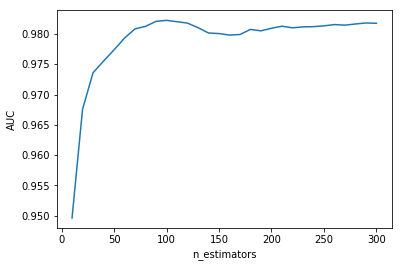

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(estimator_range, AUC_scores)
plt.xlabel('n_estimators')
plt.ylabel('AUC')

In [71]:
print(sorted(zip(AUC_scores, estimator_range), reverse=True)[0])
n,estimator = sorted(zip(AUC_scores, estimator_range), reverse=True)[0]


(0.9822390616892335, 100)


In [0]:
# De igual forma iteramos para obtener el mejor valor de max_depth
from sklearn.model_selection import cross_val_score
# Lista de valores para "max_depth"
max_depth_range = np.linspace(1, 32, 32, endpoint=True)

# Definir un lista para almacenar los promedios de los Auc por cada valor de "max_depth"
AUC_scores = []

# Usa una validación cruzada de 10 folds con cada valor del "max_depth"
for depth in max_depth_range:
    rfcla = RandomForestClassifier(n_estimators=estimator,max_depth=depth,random_state=1)
    AUC_score = cross_val_score(rfcla, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
    AUC_scores.append(np.mean(AUC_score))

Text(0, 0.5, 'AUC')

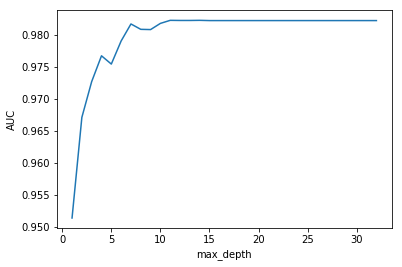

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
# Graficar max_depth (eje x) versus AUC (eje y)
plt.plot(max_depth_range, AUC_scores)
plt.xlabel('max_depth')
plt.ylabel('AUC')

In [74]:
# Muestra el mejor AUC y el correspondiente "max_depth"
print(sorted(zip(AUC_scores, max_depth_range), reverse=True)[0])
n,depth = sorted(zip(AUC_scores, max_depth_range), reverse=True)[0]


(0.9822772442016428, 14.0)


In [0]:
# De igual forma iteramos para obtener el mejor valor de min_samples_split
from sklearn.model_selection import cross_val_score
# Lista de valores para "min_samples_split"
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

# Definir un lista para almacenar los promedios de los Auc por cada valor de "max_depth"
AUC_scores = []

# Usa una validación cruzada de 10 folds con cada valor del "min_samples_split"
for min_samples_split in min_samples_splits:
    rfcla = RandomForestClassifier(n_estimators=estimator,max_depth=depth,random_state=1,min_samples_split=min_samples_split)
    AUC_score = cross_val_score(rfcla, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
    AUC_scores.append(np.mean(AUC_score))

Text(0, 0.5, 'AUC')

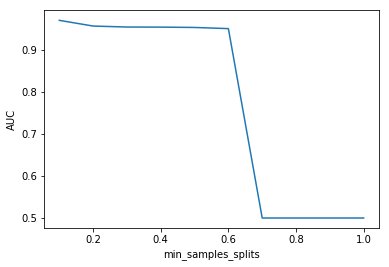

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt
# Graficar max_depth (eje x) versus AUC (eje y)
plt.plot(min_samples_splits, AUC_scores)
plt.xlabel('min_samples_splits')
plt.ylabel('AUC')

In [79]:
# Muestra el mejor AUC y el correspondiente "min_samples_split"
print(sorted(zip(AUC_scores, min_samples_splits), reverse=True)[0])
n,min_samples_split = sorted(zip(AUC_scores, min_samples_splits), reverse=True)[0]

(0.9710991668379985, 0.1)


In [0]:
# De igual forma iteramos para obtener el mejor valor de min_samples_leafs
from sklearn.model_selection import cross_val_score

min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

# Definir un lista para almacenar los promedios de los Auc por cada valor de "min_samples_leaf"
AUC_scores = []

# Usa una validación cruzada de 10 folds con cada valor del "min_samples_split"
for min_samples_leaf in min_samples_leafs:
    rfcla = RandomForestClassifier(n_estimators=estimator,max_depth=depth,random_state=1,min_samples_split=min_samples,min_samples_leaf=min_samples_leaf)
    AUC_score = cross_val_score(rfcla, X_train, y_train.values.ravel(), cv=5, scoring='roc_auc')
    AUC_scores.append(np.mean(AUC_score))

Text(0, 0.5, 'AUC')

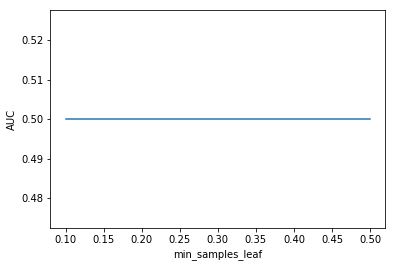

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
# Graficar max_depth (eje x) versus AUC (eje y)
plt.plot(min_samples_leafs, AUC_scores)
plt.xlabel('min_samples_leaf')
plt.ylabel('AUC')

In [82]:

# Muestra el mejor AUC y el correspondiente "min_samples_leaf"
print(sorted(zip(AUC_scores, min_samples_leafs), reverse=True)[0])
n,min_samples_leafs = sorted(zip(AUC_scores, min_samples_leafs), reverse=True)[0]

(0.5, 0.5)


**Probando con los mejores valores calculados**


In [84]:
print ("Mejor valores")
print("n_estimator: ",estimator)
print("max_depth: ",depth)
print("min_samples_split :",min_samples_split) # No se considerará
print("min_samples_leafs :",min_samples_leafs) # No se considerará

Mejor valores
n_estimator:  100
max_depth:  14.0
min_samples_split : 0.1
min_samples_leafs : 0.5


In [0]:
rfreg = RandomForestClassifier(n_estimators=estimator,
                               max_depth=depth)

In [103]:
rfreg.fit(X_train, y_train.values.ravel())
 
y_predict = rfreg.predict(X_val)

tup_y_predict = list(y_predict)
tup_y_train = list(np.transpose(y_val['Tumor']))

tup_y_predict = [int(i) for i in tup_y_predict]


print ("Exactitud de RandomForest en conjunto de entrenamiento :", rfreg.score(X_train, y_train.values.ravel()))
print ("Exactitud de RandomForest en conjunto de validación    :", rfreg.score(X_val, y_val.values.ravel()))
print ("Kappa Score de RandomForest en conjunto de validación  :", cohen_kappa_score(tup_y_train,tup_y_predict))

Exactitud de RandomForest en conjunto de entrenamiento : 1.0
Exactitud de RandomForest en conjunto de validación    : 1.0
Kappa Score de RandomForest en conjunto de validación  : 1.0


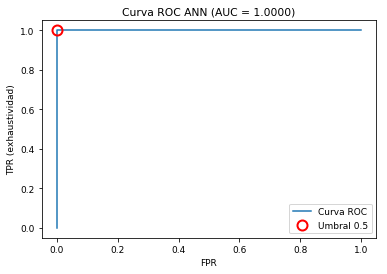

In [104]:
# Curva ROC
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred_val = rfreg.predict(X_val)
fpr, tpr, umbrales = metrics.roc_curve(y_val.values.ravel(), y_pred_val)
auc_roc = metrics.roc_auc_score(y_val.values.ravel(), y_pred_val)

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC ANN (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc=4, numpoints=1)

In [105]:
matriz_confusion = metrics.confusion_matrix(y_val.values.ravel(), y_pred_val)

# Mapeo según http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
TN = matriz_confusion[0,0]
FN = matriz_confusion[1,0]
FP = matriz_confusion[0,1]
TP = matriz_confusion[1,1]

print ('              +-----------------+')
print ('              |   Predicción    |')
print ('              +-----------------+')
print ('              |    +   |    -   |')
print ('+-------+-----+--------+--------+')
print ('| Valor |  +  |   %d  |   %d   |'   % (TP, FN) )
print ('| real  +-----+--------+--------+')
print ('|       |  -  |   %d   |   %d  |'    % (FP, TN) )
print ('+-------+-----+--------+--------+')
print ()
print ( 'Exactitud    : ', (TP+TN)/(TP+FN+FP+TN) )

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   94  |   0   |
| real  +-----+--------+--------+
|       |  -  |   0   |   17  |
+-------+-----+--------+--------+

Exactitud    :  1.0


## Ensemble

In [0]:
df = pd.read_csv('dataset_smoted.csv', sep = ",", header=0)
X = df.iloc[:,1:]
y = df[['Tumor']]
X = X.astype('float')
X = X.drop(['Tumor'], axis=1)

In [0]:
X_test = pd.read_csv('df_carac_test.csv', sep = ",", header=0, index_col=0)
y_test = pd.read_csv('df_y_test.csv', sep = ",", header=0, index_col=0)
X_test = X_test[X.columns]

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [0]:
from sklearn import datasets
from itertools import product
from mlxtend.classifier import EnsembleVoteClassifier
import copy

In [0]:
clf1 = modelo_svm = SVC(kernel='linear', C = mejor_C, probability=True)
clf2 = MLPClassifier(solver='lbfgs', alpha=1e-5, activation='relu', hidden_layer_sizes=(2, mejor_num_neurons_hidden), random_state = 13)
clf3 = GaussianNB(priors = None, var_smoothing = mejor_smoothing)
clf4 = RandomForestClassifier(n_estimators=100,max_depth=14,random_state=1,min_samples_split=0.1,min_samples_leaf=0.1)

In [0]:
clf1.fit(X_train, y_train.values.ravel())
clf2.fit(X_train, y_train.values.ravel())
clf3.fit(X_train, y_train.values.ravel())
clf4.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.1, min_samples_split=0.1,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [0]:
predicciones_base_train = pd.concat([pd.DataFrame(clf1.predict_proba(X_train)),
                                     pd.DataFrame(clf2.predict_proba(X_train)),
                                     pd.DataFrame(clf3.predict_proba(X_train)),
                                     pd.DataFrame(clf4.predict_proba(X_train))], axis=1)
predicciones_base_train.columns = ['SVM_0', 'SVM_1', 'NN_0', 'NN_1', 'NB_0', 'NB_1', 'RF_0', 'RF_1']

In [0]:
predicciones_base_train['Tumor'] = y_train.values

In [0]:
predicciones_base_train = predicciones_base_train.round(4)

In [0]:
predicciones_base_train.head()

,SVM_0,SVM_1,NN_0,NN_1,NB_0,NB_1,RF_0,RF_1,Tumor
0,0.0000,1.0000,0.0000,1.0000,0.0,1.0,0.2682,0.7318,1
1,1.0000,0.0000,0.9393,0.0607,1.0,0.0,0.9315,0.0685,0
2,0.9973,0.0027,0.9393,0.0607,1.0,0.0,0.8475,0.1525,0
3,0.0000,1.0000,0.0000,1.0000,0.0,1.0,0.2588,0.7412,1
4,0.9854,0.0146,0.9393,0.0607,1.0,0.0,0.5961,0.4039,0


In [0]:
np.random.seed(43)

df = pd.DataFrame(columns=('w1', 'w2', 'w3', 'w4', 'recall', 'specificity', 'precision', 'npv', 'accuracy', 'mcc'))

i = 0
for w1 in range(0,6):
  for w2 in range(0,6):
    for w3 in range(0,6):
      for w4 in range(0,6):

          if len(set((w1,w2,w3,w4))) == 1: 
            continue

          eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3, clf4], weights=[w1, w2, w3, w4], refit=False, voting='soft')
          eclf.fit(X_train, y_train.values.ravel())
          y_predict = eclf.predict(X_val)
          
          c_matrix = confusion_matrix(y_val,y_predict)
          recall = tp/(tp+fn)
          specificity = tn/(tn+fp)
          precision = tp/(tp+fp)
          npv = tn/(tn+fn)
          accuracy = (tp+tn)/(tp+tn+fp+fn)
          mcc = (tp*tn-fp*fn)/((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**(1/2.0)
          
#         score = eclf.score(X_val,y_val.values.ravel())
          df.loc[i] = [w1, w2, w3, w4, recall, specificity, precision, npv, accuracy, mcc]
          i += 1

In [0]:
df.sort_values(by=['recall'], ascending=False).head(15)

KeyError: ignored

In [0]:
df.loc[df['recall'].idxmax()]

w1             1.000000
w2             1.000000
w3             1.000000
w4             2.000000
recall         1.000000
specificity    0.833333
precision      0.982456
npv            1.000000
accuracy       0.983871
mcc            0.904828
Name: 0, dtype: float64

In [0]:
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3, clf4], weights=[1, 1, 1, 2], refit=False, voting='soft')
eclf.fit(X, y.values.ravel())

In [0]:
X.shape

(1948, 9082)

In [0]:
X_test.shape

(124, 9081)

In [0]:
y_predict = eclf.predict(X_test)

In [0]:
c_matrix = confusion_matrix(y_test,y_predict)
c_matrix

array([[ 11,   1],
       [  5, 107]])

In [0]:
tn = c_matrix[0,0]
tp = c_matrix[1,1]
fn = c_matrix[1,0]
fp = c_matrix[0,1]

print("Verdaderos negativos:", tn)
print("Verdaderos positivos:", tp)
print("falsos negativos", fn)
print("falsos positivos:", fp)

Verdaderos negativos: 11
Verdaderos positivos: 107
falsos negativos 5
falsos positivos: 1


In [0]:
print("Recall:", tp/(tp+fn))
print("Specificity:", tn/(tn+fp))
print("Precision:", tp/(tp+fp))
print("Negative predictive value:", tn/(tn+fn))
print("Acuracy:", (tp+tn)/(tp+tn+fp+fn))
print("Matthews correlation coefficient:", (tp*tn-fp*fn)/((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**(1/2.0))

Recall: 0.9553571428571429
Specificity: 0.9166666666666666
Precision: 0.9907407407407407
Negative predictive value: 0.6875
Acuracy: 0.9516129032258065
Matthews correlation coefficient: 0.7690527124423859


In [0]:
cohen_kappa_score(y_test,y_predict)

0.9003215434083601